# Homework 2 (HW2)
By the end of this homework, we expect you to be able to:

- Preprocess data and make it amenable to statistical analysis and machine learning models;
- Train and test out-of-the-box machine learning models in Python;
- Carry out simple multivariate regression analyses;
- Use techniques to control for covariates;
- Conduct an observational study and reason about its results.

---

- Homework release: Fri 17 Nov 2023	

- **Homework Due**: Fri 01 Dec 2023, 23:59	

- Grades released: Mon 11 Dec 2023	


---

## Some rules
1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.

2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)

3. Be sure to provide a concise textual description of your thought process, the assumptions you made, the solution you implemented, and explanations for your answers. A notebook that only has code cells will not suffice.

4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation **(in markdown)**.

5. Back up any hypotheses and claims with data, since this is an important aspect of the course.

6. Please write all your comments in **English**, and use meaningful variable names in your code. Your repo should have a single notebook (plus the required data files) in the master/main branch. **If there are multiple notebooks present, we will not grade anything.**

7. We will **not run your notebook for you!** Rather, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

8. In continuation to the previous point, interactive plots, such as those generated using the `plotly` package, should be strictly avoided!

9. Make sure to print results and/or dataframes that confirm you have properly addressed the task.


---

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats


# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

## Context

After two years, the EPFL Baseball Club is broke. The new Dean transferred all funds to EPFL's new poster child: its super-competitive Pétanque club. After struggling so much to learn about baseball, you have unfortunately been laid off...

*(...) 1 month after, you manage to get another job (!) (...)*

Congratulations! You have just been hired as a data scientist at the Association for Computational Linguistics (ACL), a professional organization for people working on natural language processing. The ACL organizes several of the top conferences and workshops in the field of computational linguistics and natural language processing.
Your boss, Dr. Tiancheng, knows of your expertise in observational studies and asks you to investigate a question that’s been bothering everyone who has ever submitted a paper to a conference: should I spend time on writing rebuttals?



---

## Rebuttals, conferences, and getting your papers accepted

Rebuttals in ACL (Association for Computational Linguistics) conferences and in many other academic conferences are an important part of the peer-review process. They allow authors of submitted papers to respond to the reviews and comments provided by the reviewers before a final decision is made regarding the acceptance of the paper. Here's how the rebuttal process typically works in ACL conferences:

- Paper Submission: Authors submit their research papers to the ACL conference for review. These papers present novel research findings in computational linguistics, natural language processing, and related areas.
- Peer Review: The papers undergo a peer-review process after the initial submission. The program committee or reviewers are experts in the field who evaluate the papers based on their quality, significance, novelty, methodology, and other relevant criteria. They provide comments and scores for each paper.
- Rebuttal Period: After receiving the reviews, authors are given a specific period (usually around a week) to write a rebuttal. The rebuttal is a formal response to the reviewers' comments. It allows authors to clarify misunderstandings, address concerns, and provide additional information to support their paper's quality. 
- Final Review: After receiving the rebuttals, the reviewers may reconsider their initial assessments in light of the authors' responses. Reviewers may choose to maintain or adjust their reviews and scores based on the quality and effectiveness of the author's rebuttal.
- Final Decision: The program committee or conference organizers consider the initial reviews/scores, rebuttals, and revised reviews/scores to make a final decision on the acceptance of the papers. The decision can be acceptance, rejection, or conditional acceptance with a request for revisions.


---

## Data

- `tmp_id`: Unique identifier for each paper in the format "P{number}".
- `status`: Accept or Reject.
- `submission_type`: Short vs. Long (papers can have different lengths). We do not use this column in this homework. 
- `track`: Track to which the paper was submitted, broadly speaking, the "topic" of the paper.
- `scores_before`: Scores received before rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework. 
- `scores_after`: Scores received after rebuttal. This is a nested JSON with many fields, but we will use only the "overall" score for the homework.
- `had_rebuttal`: True or False.


Note that: 
 - reviews are assigned numbers, e.g., "2";
 - papers can have different numbers of reviews;
 - review numbers are arbitrary, e.g., `P1` in the dataframe has two reviews numbered "2" and "3" (but no review "1").


## Task 1 (10 pts): Get to Know Your Data

As a good data scientist, you first load the data and perform some small sanity checks on it.

- You are expected to continuously alter your dataframe as you complete the tasks. E.g., if you are asked to filter the data in a specific task, continue using the filtered dataset in the subsequent tasks.
- When we tell you to "print the dataframe," make sure you print it in a way that shows the total number of rows and columns in it (`display(df)` should suffice).

**1.1** Load the dataset containing ACL reviews into memory using pandas. 
- For each paper, create rows `overall_score_before_avg` and `overall_score_after_avg` containing the average (overall) scores before and after rebuttal.
- For each paper, create rows `overall_score_before_std` and `overall_score_after_std` containing the standard deviation of the overall scores before and after the rebuttal.
- Print the four newly created rows for paper `P17`.
- Print the resulting dataframe.

We define the `reviews_df` dataframe, which contains the ACL reviews.

In [2]:
# load ACL reviews data
reviews_df = pd.read_json('data/acl18_v1_numerical_final.json')

# convert scores_before and scores_after to dictionaries
reviews_df['scores_before'] = reviews_df['scores_before'].apply(lambda x: dict(x))
reviews_df['scores_after'] = reviews_df['scores_after'].apply(lambda x: dict(x))

In [3]:
# define lamda functions for average and standard deviation of overall score
avg = lambda x: np.average([entry['scores']['overall_score'] for entry in x.values()])
std = lambda x: np.std([entry['scores']['overall_score'] for entry in x.values()])

# add columns for average and standard deviation of overall score before
reviews_df['overall_score_before_avg'] = reviews_df['scores_before'].apply(avg)
reviews_df['overall_score_before_std'] = reviews_df['scores_before'].apply(std)

# add columns for average and standard deviation of overall score after
reviews_df['overall_score_after_avg'] = reviews_df['scores_after'].apply(avg)
reviews_df['overall_score_after_std'] = reviews_df['scores_after'].apply(std)

In [4]:
# find the index of the paper with id P17
P17_index = reviews_df[reviews_df['tmp_id'] == 'P17'].index[0]

# print average and standard deviation of overall score before and after for paper P17
print('Average overall score before:', reviews_df['overall_score_before_avg'][P17_index])
print('Standard deviation of overall score before:', reviews_df['overall_score_before_std'][P17_index])
print('Average overall score after:', reviews_df['overall_score_after_avg'][P17_index])
print('Standard deviation of overall score after:', reviews_df['overall_score_after_std'][P17_index])

Average overall score before: 4.5
Standard deviation of overall score before: 0.5
Average overall score after: 4.5
Standard deviation of overall score after: 0.5


In [5]:
print("Size of reviews_df:", reviews_df.size, reviews_df.shape)
display(reviews_df)

Size of reviews_df: 16918 (1538, 11)


,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,overall_score_after_std
0,P1,Reject,Long,Machine Learning,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,2.500000,0.500000,2.500000,0.500000
1,P2,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.333333,0.942809,3.333333,0.942809
2,P3,Accept,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",True,4.666667,0.471405,4.666667,0.471405
3,P4,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,3.000000,0.816497,2.666667,1.247219
4,P5,Reject,Long,Document Analysis,"{'2': {'scores': {'originality': 2, 'soundness...","{'2': {'scores': {'originality': 2, 'soundness...",True,3.000000,0.000000,2.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
1540,P1541,Reject,Short,Textual Inference and Other Areas of Semantics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.333333,0.471405,2.333333,0.471405
1541,P1542,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.816497,2.000000,0.816497
1542,P1543,Reject,Long,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.666667,0.942809,2.666667,0.942809
1543,P1544,Reject,Short,Social Media,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.000000,2.000000,0.000000


**1.2** Create a single plot with 14 inches of width and 4 inches of height. The plot should contain two panels: 
- **Panel A**: The distribution of `overall_score_before_avg` for papers that were accepted and papers that were rejected.
- **Panel B**: The distribution of `overall_score_before_avg` for papers that had rebuttals vs. papers that did not.

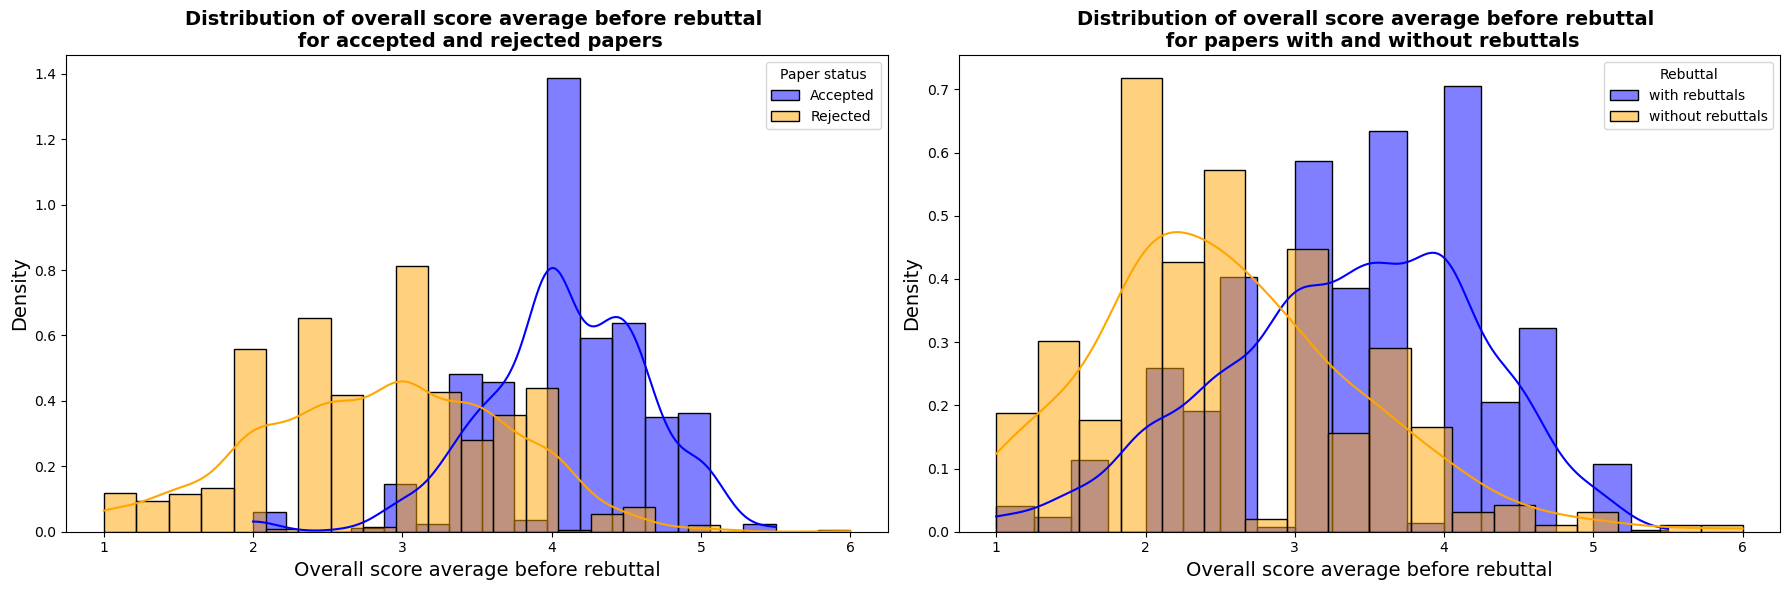

In [6]:
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Data for the first subplot
accepted_paper = reviews_df[reviews_df['status'] == 'Accept']['overall_score_before_avg']
rejected_paper = reviews_df[reviews_df['status'] == 'Reject']['overall_score_before_avg']

# Plotting the first subplot with density instead of count
sns.histplot(accepted_paper, label='Accepted', color='blue', ax=ax1, kde=True, alpha=0.5, stat="density")
sns.histplot(rejected_paper, label='Rejected', color='orange', ax=ax1, kde=True, alpha=0.5, stat="density")
ax1.legend(title='Paper status')
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel('Overall score average before rebuttal', fontsize=14)
ax1.set_title('Distribution of overall score average before rebuttal \n for accepted and rejected papers', fontsize=14, fontweight='bold')

# Data for the second subplot
had_rebuttal = reviews_df[reviews_df['had_rebuttal'] == True]['overall_score_before_avg']
no_rebuttal = reviews_df[reviews_df['had_rebuttal'] == False]['overall_score_before_avg']

# Plotting the second subplot with density instead of count
sns.histplot(had_rebuttal, label='with rebuttals', color='blue', ax=ax2, kde=True, alpha=0.5, stat="density")
sns.histplot(no_rebuttal, label='without rebuttals', color='orange', ax=ax2, kde=True, alpha=0.5, stat="density")
ax2.legend(title='Rebuttal')
ax2.set_ylabel('Density', fontsize=14)
ax2.set_xlabel('Overall score average before rebuttal', fontsize=14)
ax2.set_title('Distribution of overall score average before rebuttal \n for papers with and without rebuttals', fontsize=14, fontweight='bold')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**1.3** **/Discuss/:** If you know a paper had a rebuttal, is it more or less likely that it was accepted? Does this mean that rebuttals help papers get accepted? Explain why or why not, providing a concrete example.

**E(overall score before avarage|with rebuttals) > E(overall score before avarage|without rebuttals)**

- From the first graph, we can see two distinct distributions: one for papers that were **accepted** (`blue`) and one for those that were **rejected** (`orange`). The peak of the accepted papers' distribution is around the score of **4**, while the rejected papers' peak is around **3**. This suggests that papers with higher scores are more likely to be **accepted**.

- The second graph shows a comparison between the scores of papers that had a **rebuttal** (`blue`) and those that did not (`orange`). The peak for papers with **rebuttals** is higher than for those without, suggesting that papers with **rebuttals** tend to have higher overall scores. 

- The conclusion that might be drawn is that the **rebuttal** submission appears to increase the score and hence increase the chances of the paper being **accepted**. This could be due to the fact that **rebuttals** allow authors to clarify concerns and potentially improve their overall evaluation score. 

- **Concrete Example:** Let's consider a scenario where a paper initially receives a borderline grade (from **2.5** to **3.9**). It is not immediately **accepted**. The authors submit a strong **rebuttal**, which leads to an increase in the paper's score and eventual **acceptance**.

 -> This suggests that we can naively say that **rebuttals** play a role in potentially influencing the final decision. However, some confounding factors might be at play here and bias our conclusion. We need to investigate further to confirm our hypothesis with statistical tests.

**1.4** Print the percentage of rebuttals per track in the conference (defined by the `track` column). 

**/Discuss:/** Using "the logic" of hypothesis testing (see slide 29 of Lecture 4), how would you devise a statistical test to refute the following null hypothesis: all tracks have the same fraction of papers with rebuttals. Your statistical test should consider all categories at once, rather than comparing the fraction of rebuttals between pairs of categories.

In [7]:
# compute the percentable of rebuttals equals true per track
rebuttal_percent = reviews_df.groupby('track')['had_rebuttal'].mean() * 100
print("Percentage of rebuttals per track:")
for track in rebuttal_percent.index:
    print(f" - {track}: {rebuttal_percent[track]:.2f}%")

Percentage of rebuttals per track:
 - Dialogue and Interactive Systems: 77.53%
 - Discourse and Pragmatics: 80.43%
 - Document Analysis: 73.00%
 - Generation: 77.97%
 - Information Extraction and Text Mining: 76.84%
 - Linguistic Theories Cognitive Modeling and Psycholinguistics: 75.00%
 - Machine Learning: 80.87%
 - Machine Translation: 82.08%
 - Multidisciplinary and Area Chair COI: 68.00%
 - Multilinguality: 80.65%
 - Phonology Morphology and Word Segmentation: 85.19%
 - Question Answering: 72.84%
 - Resources and Evaluation: 73.24%
 - Sentence-level semantics: 78.89%
 - Sentiment Analysis and Argument Mining: 78.82%
 - Social Media: 73.77%
 - Summarization: 74.51%
 - Tagging Chunking Syntax and Parsing: 77.05%
 - Textual Inference and Other Areas of Semantics: 77.19%
 - Vision Robotics Multimodal Grounding and Speech: 81.13%
 - Word-level Semantics: 86.08%


First, we define our hypotheses:
- **Null Hypothesis**: All tracks have the same fraction of papers with **rebuttals**.
- **Alternative Hypothesis**: There is at least one track with a different fraction of papers with **rebuttals** compared to the others.

Since we are working with categorical data and we are seeking to compare all categories at once, a **Chi-squared** test is the most appropriate one.

The **Chi-squared test** will test whether the distribution of the `had_rebuttal` differs across the levels of the track variable. We calculate the **p-value** and decide from the p-value the conclusion:

(assuming we use a significance level of 0.05)

- If the **p-value** is **smaller** than 0.05: we reject the null hypothesis. This suggests that there is a statistically significant difference in the fraction of papers with **rebuttals** across different tracks.
- If the **p-value** is **larger** than 0.05: we cannot reject the null hypothesis, meaning that we cannot conclude that all tracks have the same fraction of papers with **rebuttals**.

## Task 2 (10pts): Prediction

You decide to investigate further the effect of rebuttals on acceptance using your machine learning skills.


**2.1** For each possible value in the `track` column, create a new column called {track}-onehot (e.g., for track=Generation, create Generation-onehot). Collectively, these new columns should "one hot-encode" the track column---for instance, if for a given paper the `track` column is filled with the value "Generation", the Generation-onehot column should equal 1 and all other {track}-onehot columns should equal 0. 

Print the column names of the resulting dataframe.

In [8]:
# one-hot encode the 'track' column and add suffix
onehot_df = pd.get_dummies(reviews_df['track'], dtype=np.int64).add_suffix('-onehot')

# concatenate the one-hot encoded columns with the original dataframe
reviews_df = pd.concat([reviews_df, onehot_df], axis=1)

print("Columns names:", reviews_df.columns)

Columns names: Index(['tmp_id', 'status', 'submission_type', 'track', 'scores_before',
       'scores_after', 'had_rebuttal', 'overall_score_before_avg',
       'overall_score_before_std', 'overall_score_after_avg',
       'overall_score_after_std', 'Dialogue and Interactive Systems-onehot',
       'Discourse and Pragmatics-onehot', 'Document Analysis-onehot',
       'Generation-onehot', 'Information Extraction and Text Mining-onehot',
       'Linguistic Theories Cognitive Modeling and Psycholinguistics-onehot',
       'Machine Learning-onehot', 'Machine Translation-onehot',
       'Multidisciplinary and Area Chair COI-onehot', 'Multilinguality-onehot',
       'Phonology Morphology and Word Segmentation-onehot',
       'Question Answering-onehot', 'Resources and Evaluation-onehot',
       'Sentence-level semantics-onehot',
       'Sentiment Analysis and Argument Mining-onehot', 'Social Media-onehot',
       'Summarization-onehot', 'Tagging Chunking Syntax and Parsing-onehot',
       'T


**2.2** Create a column `had_rebuttal_int`, which equals 1 if the paper had a rebuttal, and 0 otherwise, and a column `accepted_int`, which equals 1 if the paper was accepted, and 0 otherwise. 

In [9]:
# create the 'had_rebuttal_int' column
reviews_df['had_rebuttal_int'] = reviews_df['had_rebuttal'].apply(lambda x: 1 if x else 0)

# create the 'accepted_int' column
reviews_df['accepted_int'] = reviews_df['status'].apply(lambda x: 1 if x == 'Accept' else 0)

**2.3** Create a function `numpy_helper(df, cols)` to obtain a numpy.array out of your dataframe. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension `(NxM)` cast as a float.

In [10]:
def numpy_helper(df, cols):
    """
    Helper function to convert a dataframe to a numpy array 
    casting all columns to float
    """
    return df[cols].to_numpy(dtype ='float')

**2.4**
Create:
- an array of features X containing all track one-hot features, as well as the `overall_score_before_avg`,`overall_score_before_std`, and `had_rebuttal_int`;
- an array of outcomes y containing `accepted_int`. 


Print the shapes of both X and y (e.g., `X.shape`).

In [11]:
one_hot_cols = onehot_df.columns.to_list()
X = numpy_helper(reviews_df, one_hot_cols + ['overall_score_before_avg', 'overall_score_before_std', 'had_rebuttal_int'])
y = numpy_helper(reviews_df, ['accepted_int'])
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1538, 24)
y shape: (1538, 1)



**2.5** Build two `GradientBoostingClassifier` models using `sklearn` using the default parameters:
- Model 1: predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std`.
- Model 2:  predicts the outcome `accepted_int` using the onehot encoded features related to track, as well as the `overall_score_before_avg`,`overall_score_before_std` **and** `had_rebuttal_int`.


For both models:

- Use the `cross_validate` function from `sklearn.model_selection` to compute the average precision, recall, and accuracy across test cross validation splits.

    - e.g., `cross_validate(clf, X, y, cv=30, scoring=('accuracy', 'precision', 'recall'))`

In [12]:
# First model
# exclude the last column of X which is the column had_rebuttal_int
x_1 = X[:,:-1]

print("X_1 shape:", x_1.shape)

clf_1 = GradientBoostingClassifier()
clf_1_results = cross_validate(clf_1, x_1, y.ravel(), cv=30, scoring=('accuracy','precision','recall'))

# Second model
clf_2 = GradientBoostingClassifier()
clf_2_results = cross_validate(clf_2, X, y.ravel(), cv=30, scoring=('accuracy','precision','recall'))

X_1 shape: (1538, 23)


In [13]:
print("First model results:")
print(" Average accuracy :", clf_1_results['test_accuracy'].mean())
print(" Average precision:", clf_1_results['test_precision'].mean())
print(" Average recall   :", clf_1_results['test_recall'].mean())

print("\nSecond model results:")
print(" Average accuracy :", clf_2_results['test_accuracy'].mean())
print(" Average precision:", clf_2_results['test_precision'].mean())
print(" Average recall   :", clf_2_results['test_recall'].mean())

First model results:
 Average accuracy : 0.8373303167420816
 Average precision: 0.7085207385207386
 Average recall   : 0.592948717948718

Second model results:
 Average accuracy : 0.8386500754147814
 Average precision: 0.7126813001813002
 Average recall   : 0.5957264957264959



**2.6** Determine whether the difference in accuracy of the two models is statistically significant.


In [14]:
t_stat, p_val = stats.ttest_ind(clf_1_results['test_accuracy'], clf_2_results['test_accuracy'])
print("p value is", p_val )

p value is 0.897673080747567


The **p-value** is greater than 0.05, thus we cannot reject the null hypothesis that both models have the same accuracy; the difference is **not statistically significant**.

**2.7** Contrast the results obtained in **2.6** with what you observed in **Task 1**. What advantage did the analyses in **2.6** have?

- **Task 1** Observation: We observed by looking at the plots that if a paper had a **rebuttal**, it is more likely to get better scores and hence **accepted**. The following **endorses** the idea that a **rebuttal** increases the chances of being **accepted**.

- **Task 2.6** Observation: We observed that the prediction model can predict the **acceptance** of a paper without the information about the **rebuttal** as well as the one with the information about the **rebuttal**. This fact is drawn by the statistically insignificant difference in accuracy between the two models. The following **endorses** the idea that the difference between the **acceptance** of the papers that had **rebuttal** and the **acceptance** of those who didn't is statistically insignificant. So it seems that this parameter doesn't have a significant impact on the **acceptance** of the paper.

- The **advantage of the 2.6** analysis: The machine learning model quantitatively measures the impact of including the `had_rebuttal_int` feature. This analysis is based statistical significance thus it offers a more precise understanding of its influence on **acceptance** predictions. Moreover this analysis is not based on graphical interpretations which could be subject to incorrect interpretations.

## Task 3 (12pts): Interlude



**3.1** Using the formula API from `statsmodels`, estimate the following linear regression. Report the summary of the models.
- `accepted_int ~ had_rebuttal_int`,  
- `accepted_int ~ overall_score_after_avg`
- `had_rebuttal_int ~ overall_score_before_avg`

In [15]:
reg1 = smf.ols('accepted_int ~ C(had_rebuttal_int)', data=reviews_df).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     66.22
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           8.24e-16
Time:                        19:39:38   Log-Likelihood:                -855.16
No. Observations:                1538   AIC:                             1714.
Df Residuals:                    1536   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [16]:
reg2 = smf.ols('accepted_int ~ overall_score_after_avg', data=reviews_df).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     1031.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):          1.58e-173
Time:                        19:39:38   Log-Likelihood:                -492.65
No. Observations:                1538   AIC:                             989.3
Df Residuals:                    1536   BIC:                             1000.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [17]:
reg3 = smf.ols('had_rebuttal_int ~ overall_score_before_avg', data=reviews_df).fit()
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:       had_rebuttal_int   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     240.2
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.89e-50
Time:                        19:39:38   Log-Likelihood:                -727.42
No. Observations:                1538   AIC:                             1459.
Df Residuals:                    1536   BIC:                             1470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               


**3.2** **/Discuss:/** Interpret the coefficients associated with the binary independent variables in the above models. Note that independent variables are the ones on the right-handside of the equation.

- e.g., in `had_rebuttal_int ~ overall_score_before_avg`, `overall_score_before_avg` is the independent variable.



**Model 1**: `accepted_int` = 0.2098 * `had_rebuttal_int` + 0.0838

The only model out of the three that uses a binary independant variable is the **first one**.

We see in the equation above that the fact of having a **rebuttal** seems to add on its own **20% chance** of having the paper **accepted**.



**3.3** **/Discuss:/** describe three correlations you can draw from the previous analysis. Describe their sign (i.e., whether they are positive or negative), and whether they are statistically significant (at the .05 level of significance).


- **Model 1**: `accepted_int` = 0.2098 * `had_rebuttal_int` + 0.0838.
Sign: **Positive**.
Statistical Significance: **Yes**, at the 0.05 level.
Details: The positive coefficient (0.2098) in `accepted_int` ~ `had_rebuttal_int` indicates a positive correlation between having a **rebuttal** and the probability of a paper being **accepted**. Papers that have a **rebuttal** are 20% more likely to be **accepted** compared to those without a **rebuttal**. This correlation is statistically significant, as the p-value is less than 0.05.

- **Model 2**: `accepted_int` = 0.2860 * `overall_score_after_avg` - 0.6558.
Sign: **Positive**.
Statistical Significance: **Yes**, at the 0.05 level.
Details: The positive coefficient (0.2860) in `accepted_int` ~ `overall_score_after_avg` suggests a positive correlation between the overall score after review and the probability of a paper being **accepted**. Papers with higher scores after review are more likely to be **accepted**, for every point increase in score the acceptance probability increases by approximately 29%. This correlation is statistically significant, as the p-value is less than 0.05.

- **Model 3**: `had_rebuttal_int` = 0.1651 * `overall_score_before_avg` + 0.2527.
Sign: **Positive**.
Statistical Significance: **Yes**, at the 0.05 level.
Details: The positive coefficient (0.1651) in `had_rebuttal_int` ~ `overall_score_before_avg` suggests a positive correlation between the overall score before review and the presence of a **rebuttal**. Papers with higher initial scores are more likely to include a **rebuttal**. For every point increase in score, the probability of having a **rebuttal** increases by approximately 17%. This correlation is statistically significant, as the p-value is less than 0.05.

**3.4** **/Discuss:/** Is the following statement True or False? Justify. 

The variable `overall_score_after_avg` explains more of the variance in `accepted_int`than the variable `overall_score_before_avg` explains of `had_rebuttal_int`.


- **Model 2**: `accepted_int` ~ `overall_score_after_avg`

    $R^2$ = 0.402

    This indicates that approximately **40.2%** of the variance in `accepted_int` is explained by the `overall_score_after_avg` variable.

- **Model 3**: `had_rebuttal_int` ~ `overall_score_before_avg`

    $R^2$ = 0.135

    This indicates that approximately **13.5%** of the variance in `had_rebuttal_int` is explained by `overall_score_before_avg`.

- Comparing these results, we conclude that the statement "The variable `overall_score_after_avg` explains more of the variance in `accepted_int` than the variable `overall_score_before_avg` explains of `had_rebuttal_int`" is **true** based on these models. (40.2% against 13.5%)


**3.5** **/Discuss:/** Create a causal diagram relating the following variables:
- "Sa": `overall_score_after_avg`
- "Sb": `overall_score_before_avg`
- "Re": `had_rebuttal_int`
- "Ac": `accepted_int`
- "Tr": `track`


When unsure about whether a causal relationship exists, include it in the diagram. E.g., include the arrow corresponding to the key questions around this homework, i.e., `had_rebuttal_int`->`accepted_int`, even though you are investigating whether it exists. 

You may draw your diagram using text, use Sa/Sb/Re/Ac/Tr to represent the names of the variables, and simply indicate the causal links, one per line.


Instead of drawing something like this:
![](./dagv.jpeg)

Simply write:
- Tr->Sb
- Tr->Ac
- Tr->Re
- Ac->Sb
- Re->Sb
- Sb->Sa

---

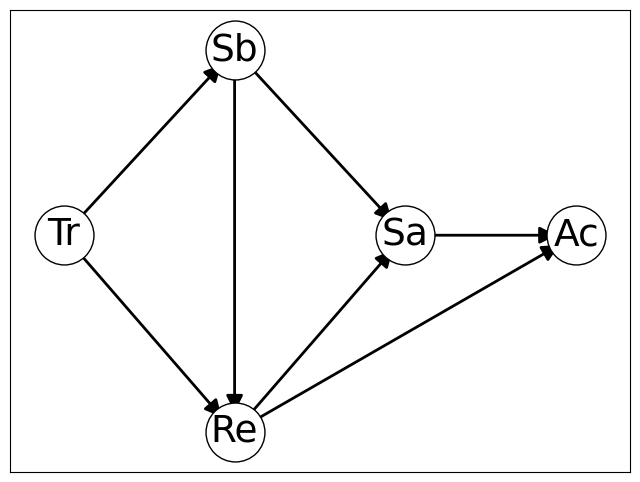

In [18]:
G = nx.DiGraph()

G.add_node("Tr")
G.add_node("Sb")
G.add_node("Re")
G.add_node("Ac")
G.add_node("Sa")

# we add our edges
G.add_edge("Tr", "Sb")
G.add_edge("Tr", "Re")
G.add_edge("Sb", "Re")
G.add_edge("Sb", "Sa")
G.add_edge("Re", "Ac")
G.add_edge("Sa", "Ac")
G.add_edge("Re", "Sa")

pos = {'Tr': (1, 0.5), 'Sb': (3,0.66), 'Re': (3, 0.33), 'Ac': (7, 0.5), 'Sa': (5, 0.5)}  
plt.figure(figsize=(8, 6))

# we create the nodes
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color='white', edgecolors='black', linewidths=1)
# we create the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, arrowsize=25, 
                       node_size=800, width=2,arrowstyle='-|>')


nx.draw_networkx_labels(G, pos, font_size=27)

plt.show()

**3.6** **/Discuss:/** What is the problem of simply comparing the outcomes of papers that had rebuttals with those that did not? Give a concrete example.

**Confounding Variables**: Several other factors (confounders) could influence both the likelihood of submitting a rebuttal and the paper's acceptance.

Concrete Example:

Imagine two groups of papers:
- **Group A** (With Rebuttals): These papers initially received moderate to **high scores** and opted to do rebuttals. The authors might have felt they had necessary clarifications.
- **Group B** (Without Rebuttals): These papers received **very low scores**, where authors felt that a rebuttal would not make a significant difference.

If we simply compare the acceptance rates of Group A and Group B, we might conclude that rebuttals significantly impact acceptance. However, this ignores the initial quality of the papers.

To get rid of confunders, we need to perform a matching.

# Task 4 (12 pts): Observational study

You decide to use your observational study skills to obtain a concrete answer to the question: do rebuttals increase acceptance?

 **4.1** Perform exact one-to-one matching considering the `score_before_avg` and the `track` variables. Each paper that had a rebuttal ("treatment group") should be matched to a paper that did not have a rebuttal ("control group"). 
- Your matching should be optimal, i.e., the maximum amount of papers possible must be matched. 
- Print the dataframe of papers in the matched sample

We define the `treatment_df` dataframe, which contains the papers that had a rebuttal, and the `control_df` dataframe, which contains the papers that did not have a rebuttal.

In [19]:
# define the treatment and control groups
treatment_df = reviews_df[reviews_df['had_rebuttal'] == 1]
control_df = reviews_df[reviews_df['had_rebuttal'] == 0]

# create a bipartite graph
G = nx.Graph()

# add edges for exact matches
for c_index, c_row in control_df.iterrows():
  for t_index, t_row in treatment_df.iterrows():
    if ((c_row['track'] == t_row['track']) &
        ((c_row['overall_score_before_avg'] == t_row['overall_score_before_avg']))):
      G.add_edge(c_index, t_index)

# generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

We define the `matched_df` dataframe, which contains the matched papers.

In [20]:
# define the matched indices
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
# create a dataframe of the matched indices
matched_df = reviews_df.loc[matched]
print("Matched dataframe shape:", matched_df.shape)
display(matched_df)

Matched dataframe shape: (542, 34)


,tmp_id,status,submission_type,track,scores_before,scores_after,had_rebuttal,overall_score_before_avg,overall_score_before_std,overall_score_after_avg,...,Sentence-level semantics-onehot,Sentiment Analysis and Argument Mining-onehot,Social Media-onehot,Summarization-onehot,Tagging Chunking Syntax and Parsing-onehot,Textual Inference and Other Areas of Semantics-onehot,Vision Robotics Multimodal Grounding and Speech-onehot,Word-level Semantics-onehot,had_rebuttal_int,accepted_int
1387,P1388,Reject,Long,Question Answering,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",True,2.500000,0.500000,3.000000,...,0,0,0,0,0,0,0,0,1,0
1301,P1302,Reject,Long,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",True,2.666667,1.247219,2.666667,...,0,0,0,0,0,0,0,0,1,0
1068,P1069,Accept,Long,Summarization,"{'2': {'scores': {'originality': 4, 'soundness...","{'2': {'scores': {'originality': 4, 'soundness...",True,5.000000,0.000000,4.500000,...,0,0,0,1,0,0,0,0,1,1
990,P991,Reject,Short,Machine Learning,"{'1': {'scores': {'originality': 3, 'soundness...","{'1': {'scores': {'originality': 3, 'soundness...",False,2.500000,1.500000,2.666667,...,0,0,0,0,0,0,0,0,0,0
1349,P1350,Reject,Short,Multidisciplinary and Area Chair COI,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,2.000000,0.000000,2.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,P976,Accept,Long,Generation,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",False,4.000000,1.414214,3.333333,...,0,0,0,0,0,0,0,0,0,1
185,P186,Reject,Short,Resources and Evaluation,"{'1': {'scores': {'originality': 4, 'soundness...","{'1': {'scores': {'originality': 4, 'soundness...",False,4.000000,0.000000,4.000000,...,0,0,0,0,0,0,0,0,0,0
252,P253,Reject,Long,Sentence-level semantics,"{'2': {'scores': {'originality': 3, 'soundness...","{'2': {'scores': {'originality': 3, 'soundness...",True,2.000000,0.000000,2.000000,...,1,0,0,0,0,0,0,0,1,0
660,P661,Reject,Long,Discourse and Pragmatics,"{'1': {'scores': {'originality': 2, 'soundness...","{'1': {'scores': {'originality': 2, 'soundness...",False,3.000000,1.000000,3.000000,...,0,0,0,0,0,0,0,0,0,0


**4.2** So far, we did not consider the `score_before_std` variable. One could argue that the variance in the scores makes a difference. E.g., a paper that received scores 1 and 5, might be very different from a paper with scores 3 and 3. 

Note that you did not match on the `score_before_std` variable. However, it suffices if this variable is "balanced" across treatment and control groups.
 Use the Standardized Mean Difference (SMD) to assess whether that's the case.

- The standardized mean difference for a variable $x$ and two groups $t$ and $c$ is defined as: $\frac{| E[x_t] - E[x_c] |}{\sqrt{Var[x_t] + Var[x_c]}}$

- Note that a Standardized Mean Difference smaller than 0.1 suggests that variables are balanced across treatment and control groups.


In [21]:
def SMD (df, x, t):
    '''
    Calculate standardized mean difference
    
    Args:
        df (pd.DataFrame): dataframe
        x (str): variable name
        t (str): treatment column name
        
    Returns:
        float: standardized mean difference
    '''
    exp_reb = df[df[t] == 1][x].mean()
    exp_no_reb = df[df[t] == 0][x].mean()
    var_reb = df[df[t] == 1][x].var()
    var_no_reb = df[df[t] == 0][x].var()
    return np.abs(exp_reb - exp_no_reb) / np.sqrt((var_reb + var_no_reb))

In [22]:
print("SMD:", SMD(matched_df, 'overall_score_before_std', 'had_rebuttal'))

SMD: 0.07617910673790067


Standardized Mean Difference 0.076 < 0.1 -> Variables are balanced across treatment and control groups


**4.3** Using the matched sample, estimate the following linear regression: `accepted ~ had_rebuttal_int`.


In [23]:
# Model : accepted_int ~ had_rebuttal_int tested on the matched data
model = smf.ols('accepted_int ~ C(had_rebuttal_int)', data=matched_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           accepted_int   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.07696
Date:                Fri, 01 Dec 2023   Prob (F-statistic):              0.782
Time:                        19:40:08   Log-Likelihood:                -132.72
No. Observations:                 542   AIC:                             269.4
Df Residuals:                     540   BIC:                             278.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

**4.4** **/Discuss:/**

i. Considering your results obtained in 4.3, and the causal diagram drawn in Task 3: do rebuttals increase the chance of a paper getting accepted? Why are results different from what you obtained in **Task 1?**

ii. Why is there no need to include other covariates (e.g., score before) in the regression?

i. Given the results obtained in 4.3, we observe that the **coeficient** is very low (0.7%). Furthermore, we obtained a **p-value** of 0.782, hence, we cannot reject the null hypothesis stating that the rebuttal has an impact on the acceptance of a paper. Finally, we have an $R^2$ close to 0, which indicates that the model doesn't explain the variance of the data. The change in the $R^2$ compared to the **Task 3 model** (4.2%) is due to the fact that we got rid of the confounding variables by performing a matching. We can conclude that the **rebuttal** does not increase the chance of a paper getting accepted.

In **Task 1**, we observed that papers with **rebuttals** tend to be more accepted. However, this was not a causal relationship, as we did not control confounders. In this task, we performed a matching to control confounders, and we observed that the **rebuttal** does not have a significant impact on the acceptance of a paper.

ii. Since we performed a one-to-one matching on the `score_before_avg` and the `track` variables, we can assume that these variables are **balanced** across the treatment and control groups. Therefore, we do not need to include them in the regression. Thus, **no other covariates** are needed.

**4.5** **/Discuss:/** Imagine there is another, unobserved variable "quality" which captures the true quality of the paper. Suppose quality ("Qu") is connected to the DAG you drew in the following ways:
- Qu -> Sa
- Qu -> Sb
- Qu -> Re
- Qu -> Ac

Assume that
- quality can only increase the chances of rebuttals;
- quality and the rebuttal can only increase the chance of a paper being accepted.

Does this uncontrolled confounder threaten the validity of your findings?


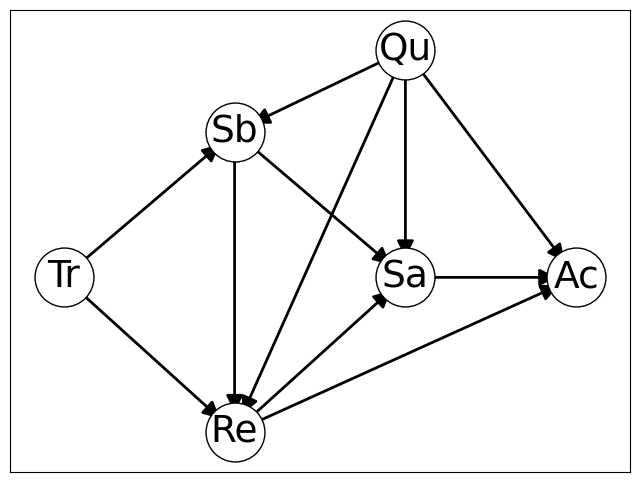

In [24]:
G = nx.DiGraph()

G.add_node("Tr")
G.add_node("Sb")
G.add_node("Re")
G.add_node("Ac")
G.add_node("Sa")
G.add_node("Qu")
# we add our edges
G.add_edge("Qu", "Sb")
G.add_edge("Qu", "Sa")
G.add_edge("Qu", "Re")
G.add_edge("Qu", "Ac")

G.add_edge("Tr", "Sb")
G.add_edge("Tr", "Re")
G.add_edge("Sb", "Re")
G.add_edge("Sb", "Sa")
G.add_edge("Re", "Ac")
G.add_edge("Sa", "Ac")
G.add_edge("Re", "Sa")

pos = {'Tr': (1, 0.5), 'Sb': (3,0.66), 'Re': (3, 0.33), 'Ac': (7, 0.5), 'Sa': (5, 0.5), 'Qu': (5, 0.75)}  
plt.figure(figsize=(8, 6))

# we create the nodes
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color='white', edgecolors='black', linewidths=1)
# we create the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, arrowsize=25, 
                       node_size=800, width=2,arrowstyle='-|>')


nx.draw_networkx_labels(G, pos, font_size=27)

plt.show()

The "quality" unobserved variable is a threat to the validity of our findings.
The "quality" has a direct effect on the **rebutal** of the paper. Thus, it is a confounder that we do not control.